#                                         Pricing Case Study

You’re launching a ride-hailing service that matches riders with drivers for trips between the Toledo Airport and Downtown Toledo. It’ll be active for only 12 months. You’ve been forced to charge riders $30 for each ride. You can pay drivers what you choose for each individual ride.

The supply pool (“drivers”) is very deep. When a ride is requested, a very large pool of drivers see a notification informing them of the request. They can choose whether or not to accept it. Based on a similar ride-hailing service in the same market, you have some data on which ride requests were accepted and which were not. (The PAY column is what drivers were offered and the ACCEPTED column reflects whether any driver accepted the ride request.)

The demand pool (“riders”) can be acquired at a cost of $30 per rider at any time during the 12 months. There are 10,000 riders in Toledo, but you can’t acquire more than 1,000 in a given month. You start with 0 riders. “Acquisition” means that the rider has downloaded the app and may request rides. Requested rides may or may not be accepted by a driver. In the first month that riders are active, they request rides based on a Poisson distribution where lambda = 1. For each subsequent month, riders request rides based on a Poisson distribution where lambda is the number of rides that they found a match for in the previous month. (As an example, a rider that requests 3 rides in month 1 and finds 2 matches has a lambda of 2 going into month 2.) If a rider finds no matches in a month (which may happen either because they request no rides in the first place based on the Poisson distribution or because they request rides and find no matches), they leave the service and never return.

Submit a written document that proposes a pricing strategy to maximize the profit of the business over the 12 months. You should expect that this singular document will serve as a proposal for

1. A quantitative executive team that wants to know how you’re thinking about the problem and what assumptions you’re making but that does not know probability theory

2. Your data science peers so they can push on your thinking

Please submit any work you do, code or math, with your solution.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
import math

# 1. Analizing the dataset

In [3]:
df = pd.read_csv("driverAcceptanceData.csv",index_col=[0])

In [4]:
df["real_profit_company"]=df["ACCEPTED"]*(30-df["PAY"]) #Real profi for that price - 0 if the offer was not accepted
df["theoretical_profit_company"]=30-df["PAY"]           #Theoretical profit

In [5]:
df.head(5)

,PAY,ACCEPTED,real_profit_company,theoretical_profit_company
0,29.358732,0,0.000000,0.641268
1,22.986847,0,0.000000,7.013153
2,18.020348,0,0.000000,11.979652
3,45.730717,1,-15.730717,-15.730717
4,14.642845,0,0.000000,15.357155


In [6]:
df.tail(3)

,PAY,ACCEPTED,real_profit_company,theoretical_profit_company
997,42.122166,1,-12.122166,-12.122166
998,10.853923,0,0.000000,19.146077
999,22.310536,0,0.000000,7.689464


## 1.1. Searching for NaN values

In [7]:
df.isna().sum().sum()

0

## 1.2. Histogram

The next histogram shows the "PAY" distribution. However, some of them were accepted but not others.

In [8]:
print("Averaged price offered to the driver :",df["PAY"].mean())
print("Standard Deviation for the price offered to the driver :",df["PAY"].std())

Averaged price offered to the driver : 25.713529861045735
Standard Deviation for the price offered to the driver : 10.05141006745325


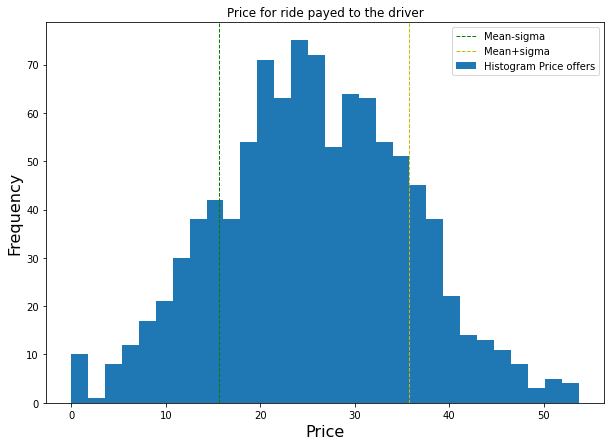

In [9]:
plt.figure(figsize=(10,7))
plt.hist(df["PAY"], bins=30)
plt.xlabel("Price", fontsize=16)  
plt.ylabel("Frequency", fontsize=16)
plt.axvline(df["PAY"].mean()-df["PAY"].std(), color='g', linestyle='dashed', linewidth=1)
plt.axvline(df["PAY"].mean()+df["PAY"].std(), color='y', linestyle='dashed', linewidth=1)
labels = ["Mean-sigma","Mean+sigma","Histogram Price offers"]
plt.legend(labels)
plt.title("Price for ride payed to the driver")
plt.show()

In [10]:
accepted=df[df["ACCEPTED"]==1]
print("Averaged pay to the driver when the trip is accepted:",accepted["PAY"].mean())
print("Profit from accpeted trips: ",(30-accepted["PAY"].mean())*len(accepted["PAY"]))

Averaged pay to the driver when the trip is accepted: 32.076047699825416
Profit from accpeted trips:  -1094.0771378079944


In [11]:
no_accepted=df[df["ACCEPTED"]==0]
print("Averaged pay to the driver when the trip is not accepted:",no_accepted["PAY"].mean())
print("Profit from NO accpeted trips: ",(30-no_accepted["PAY"].mean())*len(accepted["PAY"]))

Averaged pay to the driver when the trip is not accepted: 18.624635778515295
Profit from NO accpeted trips:  5994.81694472244


The optimus price should be between 18.62 USD and 30 USD . There is a point in that range for which the profit is maximum

In [12]:
print("Number of Trips accepted:", len(accepted["PAY"]))
print("Number of Trips no accepted:", len(no_accepted["PAY"]))
print("\n")
print("% of Trips accepted:", len(accepted["PAY"])/1000)
print("% of Trips no accepted:", len(no_accepted["PAY"])/1000)

Number of Trips accepted: 527
Number of Trips no accepted: 473


% of Trips accepted: 0.527
% of Trips no accepted: 0.473


In the next plot I want to see the behaviour of accepted and no accepted for all the different prices

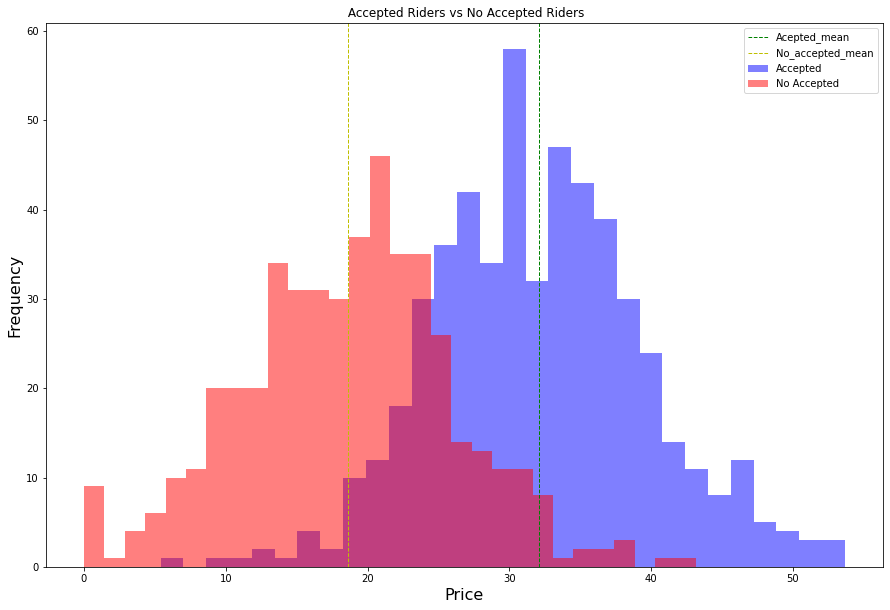

In [13]:
plt.figure(figsize=(15,10))
plt.hist(accepted["PAY"], bins=30,color="b",alpha=0.5)
plt.hist(no_accepted["PAY"], bins=30,color="r",alpha=0.5)
plt.xlabel("Price", fontsize=16)  
plt.ylabel("Frequency", fontsize=16)
plt.title(" Accepted Riders vs No Accepted Riders")
labels = ["Acepted_mean","No_accepted_mean","Accepted", "No Accepted"]
plt.axvline(accepted["PAY"].mean(), color='g', linestyle='dashed', linewidth=1)
plt.axvline(no_accepted["PAY"].mean(), color='y', linestyle='dashed', linewidth=1)
plt.legend(labels)

# plt.figure(figsize=(5,5))
# plt.hist(no_accepted["PAY"], bins=30,color="r")
# plt.hist(accepted["PAY"], bins=30,color="b")
# plt.xlabel("Price", fontsize=16)  
# plt.ylabel("Frequency", fontsize=16)
# plt.title(" Accepted Riders vs No Accepted Riders")
# labels = ["Acepted_mean","No_accepted_mean","No Accepted","Accepted"]
# plt.axvline(accepted["PAY"].mean(), color='g', linestyle='dashed', linewidth=1)
# plt.axvline(no_accepted["PAY"].mean(), color='y', linestyle='dashed', linewidth=1)
# plt.legend(labels)

plt.show()

## 1.3. Analizing the relationship between price and % of accepted request

I want to analyze the relationship between % of request accepted and the price suggested to the driver. I am going to focus in the range (10,50)

In [16]:
maximus_price=df["PAY"].max()
minimus_price=df["PAY"].min()
acepptance_rate=pd.DataFrame(columns=["price_init","price_final","%_accept","%_no_accept","avg_price"])

price_range=range(10,50)

threshold_price=1

for i in price_range:
    
    a = len(no_accepted[(no_accepted["PAY"]>i) & (no_accepted["PAY"]<=i+threshold_price)])
    
    b = len(accepted[(accepted["PAY"]>i) & (accepted["PAY"]<=i+threshold_price)]) #accepted
    
    if a>0 and b>0:
        acepptance_rate.loc[len(acepptance_rate)]=[i,i+threshold_price,(b/(a+b))*100,(a/(a+b))*100,(2*i+threshold_price)*0.5]
    
acepptance_rate

,price_init,price_final,%_accept,%_no_accept,avg_price
0,11.0,12.0,7.692308,92.307692,11.5
1,12.0,13.0,11.111111,88.888889,12.5
2,14.0,15.0,4.166667,95.833333,14.5
3,15.0,16.0,9.523810,90.476190,15.5
4,16.0,17.0,7.407407,92.592593,16.5
5,17.0,18.0,11.764706,88.235294,17.5
6,18.0,19.0,17.647059,82.352941,18.5
7,19.0,20.0,21.739130,78.260870,19.5
8,20.0,21.0,15.555556,84.444444,20.5
9,21.0,22.0,29.268293,70.731707,21.5


Notice that this is just an approximation and there is an error to consider based on the threshold_price value. The largest is the dataset the more accurate this way to calculate the relationship is.

In [18]:
acepptance_rate["profit_ride"] = 30 - acepptance_rate["avg_price"]
acepptance_rate["profit_per_request"] = acepptance_rate["profit_ride"]*acepptance_rate["%_accept"]/100

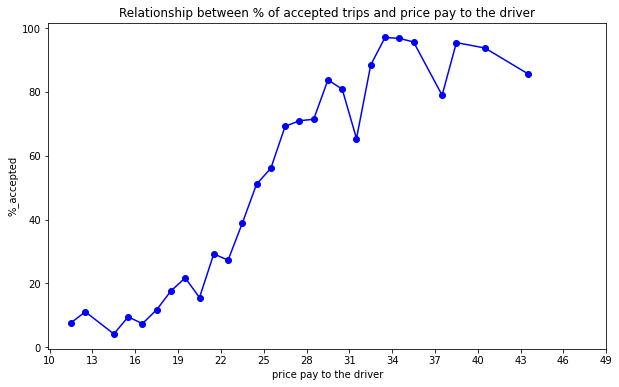

In [21]:
plt.figure(figsize=(10,6))
plt.plot(acepptance_rate["avg_price"], acepptance_rate["%_accept"], marker='o',color="b")
#plt.plot(acepptance_rate["avg_price"], acepptance_rate["%_no_accept"], marker='o',color="r")
plt.xlabel('price pay to the driver')
plt.ylabel('%_accepted')
plt.title("Relationship between % of accepted trips and price pay to the driver")
plt.xticks(price_range[0:len(price_range):3])
plt.show()

This plot shows a relationship between the % of requested accepted and the price offered to the driver

In [22]:
acepptance_rate

,price_init,price_final,%_accept,%_no_accept,avg_price,profit_ride,profit_per_request
0,11.0,12.0,7.692308,92.307692,11.5,18.5,1.423077
1,12.0,13.0,11.111111,88.888889,12.5,17.5,1.944444
2,14.0,15.0,4.166667,95.833333,14.5,15.5,0.645833
3,15.0,16.0,9.523810,90.476190,15.5,14.5,1.380952
4,16.0,17.0,7.407407,92.592593,16.5,13.5,1.000000
5,17.0,18.0,11.764706,88.235294,17.5,12.5,1.470588
6,18.0,19.0,17.647059,82.352941,18.5,11.5,2.029412
7,19.0,20.0,21.739130,78.260870,19.5,10.5,2.282609
8,20.0,21.0,15.555556,84.444444,20.5,9.5,1.477778
9,21.0,22.0,29.268293,70.731707,21.5,8.5,2.487805


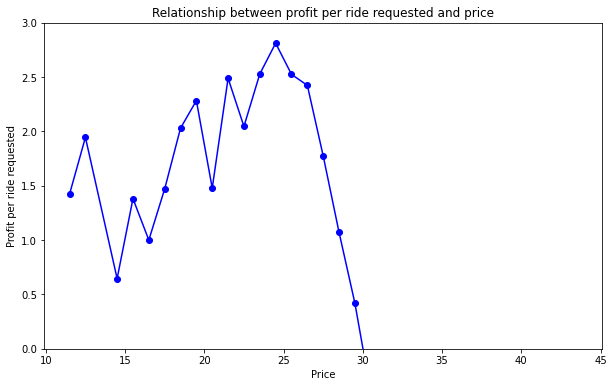

In [25]:
plt.figure(figsize=(10,6))
plt.plot(acepptance_rate["avg_price"], acepptance_rate["profit_per_request"], marker='o',color="b")
#plt.plot(acepptance_rate["avg_price"], acepptance_rate["%_no_accept"], marker='o',color="r")
plt.xlabel('Price')
plt.ylabel('Profit per ride requested')
plt.title("Relationship between profit per ride requested and price")
plt.ylim(0,3)
plt.show()

The highest profit per ride requested is for a price between 24 and 25. That means an average price of 24.5

In [43]:
maximun = acepptance_rate[acepptance_rate["avg_price"]==24.5]

In [48]:
maximun

,price_init,price_final,%_accept,%_no_accept,avg_price,profit_ride,profit_per_request
12,24.0,25.0,51.111111,48.888889,24.5,5.5,2.811111


In [49]:
optimun_price = maximun["avg_price"]
optimun_price

12    24.5
Name: avg_price, dtype: float64

In [50]:
accepted_rate = maximun["%_accept"]
accepted_rate

12    51.111111
Name: %_accept, dtype: float64

In [68]:
best_price_accepted=pd.DataFrame(columns=["Price","Accepted","Profit"])

best_price_accepted.loc[0,"Price"] = float(optimun_price)
best_price_accepted.loc[0,"Accepted"] = float(accepted_rate)
best_price_accepted.loc[0,"Profit"] = float(30-optimun_price)

In [75]:
best_price_accepted

,Price,Accepted,Profit
0,24.5,51.111111,5.5


## 1.4. Analizing the maximun profit for a Poisson Distribution

#### Constrain

## **$Active Riders + Unactive Riders <10.000$**

## **$AcquiredRiders{i} <= 1.000$  $\forall i \in {1,2...,12}$**

# 1.4.1. Some notes and assumtions

A poisson distribution is used when there is an occurrence in a period of time. The rate of that occurence under the period of time is $\lambda$. This distribution is of common use in sales.

As the poisson distribution for the next month is based on the previous one and for the first month $\lambda$ = 1

#### 1.4.1.1. I am going to assume that the first month, there are **n** users

#### 1.4.1.2. I am going to assume that there are a new random number of users every month. Noticing that the number of users can not be higher than 1000.

In [142]:
lambda1_start=1
k = np.arange(0, 20)
pmf = poisson.pmf(k, mu=lambda1_start)

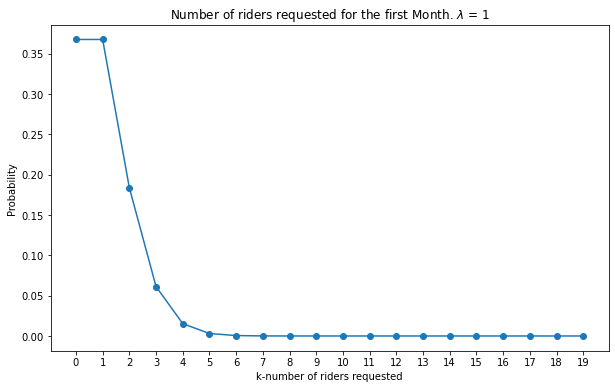

In [143]:
plt.figure(figsize=(10,6))
plt.plot(k, pmf, marker='o')
plt.xlabel('k-number of riders requested')
plt.ylabel('Probability')
plt.title("Number of riders requested for the first Month. $\lambda$ = 1")
plt.xticks(k)
plt.show()

## 1.4.1.2. Profit Expected

In [190]:
lambda1_start=1
k = np.arange(0, 20)
pmf = poisson.pmf(k, mu=lambda1_start)

In [191]:
#The first month there are n users who request a ride based on lambda = 1.
import random
n_users=100
#New users every month. a random value between the 10% and 30% of the number of users of the first month
m_low = 1
m_up = 500

In [192]:
new_users = []
for i in range(0,12):
    n = random.randint(m_low,m_up)
    new_users.append(n)
print(new_users)

[70, 188, 87, 27, 459, 236, 342, 376, 419, 259, 426, 127]


In [193]:
results=pd.DataFrame(index = range(1,12),columns=["lambda","users_active","users_inactive","total_users_inactive",
                                                  "requested","accepted"
                                                          ,"profit","total_profit","prob_list"])



# lambda : Rate user rides request/month

# users_active: Number of active users. Up to 1000. 

# users_inactive: Number of users leaving the APP that month

# total_users_inactive: Total number of users who have left the APP

# requested: Number or rides requested that month

# accepted: NUmber of rides accepted for the optimun price

# profit:  Monthly profit for all the rides accepted

# total_profit: Total profit accumulated

# prob_list: Poisson probabilities distribution for the lambda of each month

results.loc[1,"lambda"] = lambda1_start            
results.loc[1,"users_active"] = n_users            
results.loc[1,"users_inactive"] = 0               
results.loc[1,"total_users_inactive"] = 0          
results.loc[1,"requested"] = n_users*lambda1_start 
results.loc[1,"prob_list"] = pmf                  

results.loc[1,"accepted"] = results.loc[1,"requested"]*(float(best_price_accepted["Accepted"])/100)
results.loc[1,"profit"] = results.loc[1,"accepted"]*float(best_price_accepted["Profit"])
results.loc[1,"total_profit"] = results.loc[1,"profit"]

In [194]:
results.head(3)

,lambda,users_active,users_inactive,total_users_inactive,requested,accepted,profit,total_profit,prob_list
1,1,100,0,0,100,51.111111,281.111111,281.111111,"[0.36787944117144233, 0.36787944117144233, 0.1..."
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.5. Profit expected

In [195]:
for i in range(2,13):
    
    # Users staying in the APP
    users_stay_APP = (results.loc[i-1,"users_active"]*pmf[1:]).sum() #Removing users with 0 rides
    
    users_leave_App = results.loc[i-1,"users_active"]*pmf[0]
    # New users
    new_users_App = new_users[i-1]
    
    #Second constrain
    if new_users_App+users_stay_APP>1000:
        new_users_App=1000-users_stay_APP
    
    # Total users
    users_APP = new_users_App + users_stay_APP
    
    #Old users lambda
    avg_request = pmf[1:]*users_stay_APP
    
    new_prob = avg_request/(avg_request.sum())
    
    expectation_old_users = (k[1:]*new_prob).sum()
    
    # New users lambda
    expectation_new_users = 1
    
    # New lambda for all the users in the App
    new_expectation = ((expectation_new_users*new_users_App)+(users_stay_APP*expectation_old_users))/users_APP
    
    pmf = poisson.pmf(k, mu=new_expectation)
    
    results.loc[i,"lambda"] = new_expectation
    
    results.loc[i,"users_active"] = users_APP
    
    results.loc[i,"users_inactive"] = users_leave_App
    
    #results.loc[i,"total_users_inactive"] = results.loc[i-1,"total_users_inactive"]+users_leave_App

    results.loc[i,"total_users_inactive"] = (results["users_inactive"].sum())
    
    results.loc[i,"requested"] = users_APP * new_expectation #Beacause lambda = 1

    results.loc[i,"accepted"] = results.loc[i,"requested"]*(float(best_price_accepted["Accepted"])/100)
    
    results.loc[i,"profit"] = results.loc[i,"accepted"]*float(best_price_accepted["Profit"])
    
    results.loc[i,"total_profit"] = results["profit"].sum()
    
    results.loc[i,"prob_list"] = pmf

In [196]:
results

,lambda,users_active,users_inactive,total_users_inactive,requested,accepted,profit,total_profit,prob_list
1,1,100,0,0,100,51.111111,281.111111,281.111111,"[0.36787944117144233, 0.36787944117144233, 0.1..."
2,1.146442,251.212056,36.787944,36.787944,288.0,147.2,809.6,1090.711111,"[0.3177654350796173, 0.3642995754375951, 0.208..."
3,1.45132,258.385548,79.826508,116.614452,375.0,191.666667,1054.166667,2144.877778,"[0.23426096204213265, 0.33998751697009405, 0.2..."
4,1.787812,224.855901,60.529647,177.144099,402.0,205.466667,1130.066667,3274.944444,"[0.16732593613164762, 0.29914725885352705, 0.2..."
5,1.33234,646.231677,37.624224,214.768323,861.0,440.066667,2420.366667,5695.311111,"[0.2638592354225897, 0.35155008633008433, 0.23..."
6,1.541342,711.717481,170.514196,385.282519,1097.0,560.688889,3083.788889,8779.1,"[0.21409360843779557, 0.32999145712779154, 0.2..."
7,1.596506,901.343317,152.374164,537.656683,1439.0,735.488889,4045.188889,12824.288889,"[0.20260318128399143, 0.3234571915000638, 0.25..."
8,1.720272,1000.0,182.615023,720.271707,1720.271707,879.249983,4835.874908,17660.163797,"[0.17901750108097977, 0.3079587420812675, 0.26..."
9,1.899289,1000.0,179.017501,899.289208,1899.289208,970.747817,5339.112995,22999.276792,"[0.14967496925245471, 0.28427605374897025, 0.2..."
10,2.048964,1000.0,149.674969,1048.964177,2048.964177,1047.248357,5759.865964,28759.142756,"[0.12886831926656273, 0.2640465697082421, 0.27..."


# Conclusion: 

### This script shows the profit expected after the 12th month. 

### The highest profit per ride requested is for a price between [24,25].

### The total expected profit can be calculated on this script. The two inputs to understand are

####                 * Users for the firsth month

####                *  New users each month


### To show an example I have calculate the total profit for the next inputs:

####                 * Users for the firsth month: 100 users

####                *  New users each month: A random value between (0,500)

In [210]:
#For this example, the next outputs are calculated:

print("Total users left the App:",results.iloc[-1]["total_users_inactive"])
print("\n")
print("Current Users:",results.iloc[-1]["users_active"])
print("\n")
print("Total Rides Requested",results["requested"].sum())
print("\n")
print("Total Rides Accepted",results["accepted"].sum())
print("\n")
print("Total Profit",results.iloc[-1]["total_profit"])


Total users left the App: 1291.119310446429


Current Users: 1000.0


Total Rides Requested 14699.476897523651


Total Rides Accepted 7513.065969845422


Total Profit 41321.862834149826
